In [ ]:
!pip install ucimlrepo

#Importing the Data from Wisconsin Breast Cancer diagnostic dataset using python
The original dataset includes an `ID` column as an identifier. It has no diagnostic value and was excluded since the `ucimlrepo` loader already drops it.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
# we are getting the feautures and targets as pandas dataframes and they already come without the ID attribute
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# metadata
print("printing metadata\n")
print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
print("\nprinting variable information\n")
print(breast_cancer_wisconsin_diagnostic.variables)

# features and targets
print("\nprinting features\n")
print(X)
print("\nprinting targets\n")
print(y)

printing metadata

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journa

# Basic Statistics for each Feature

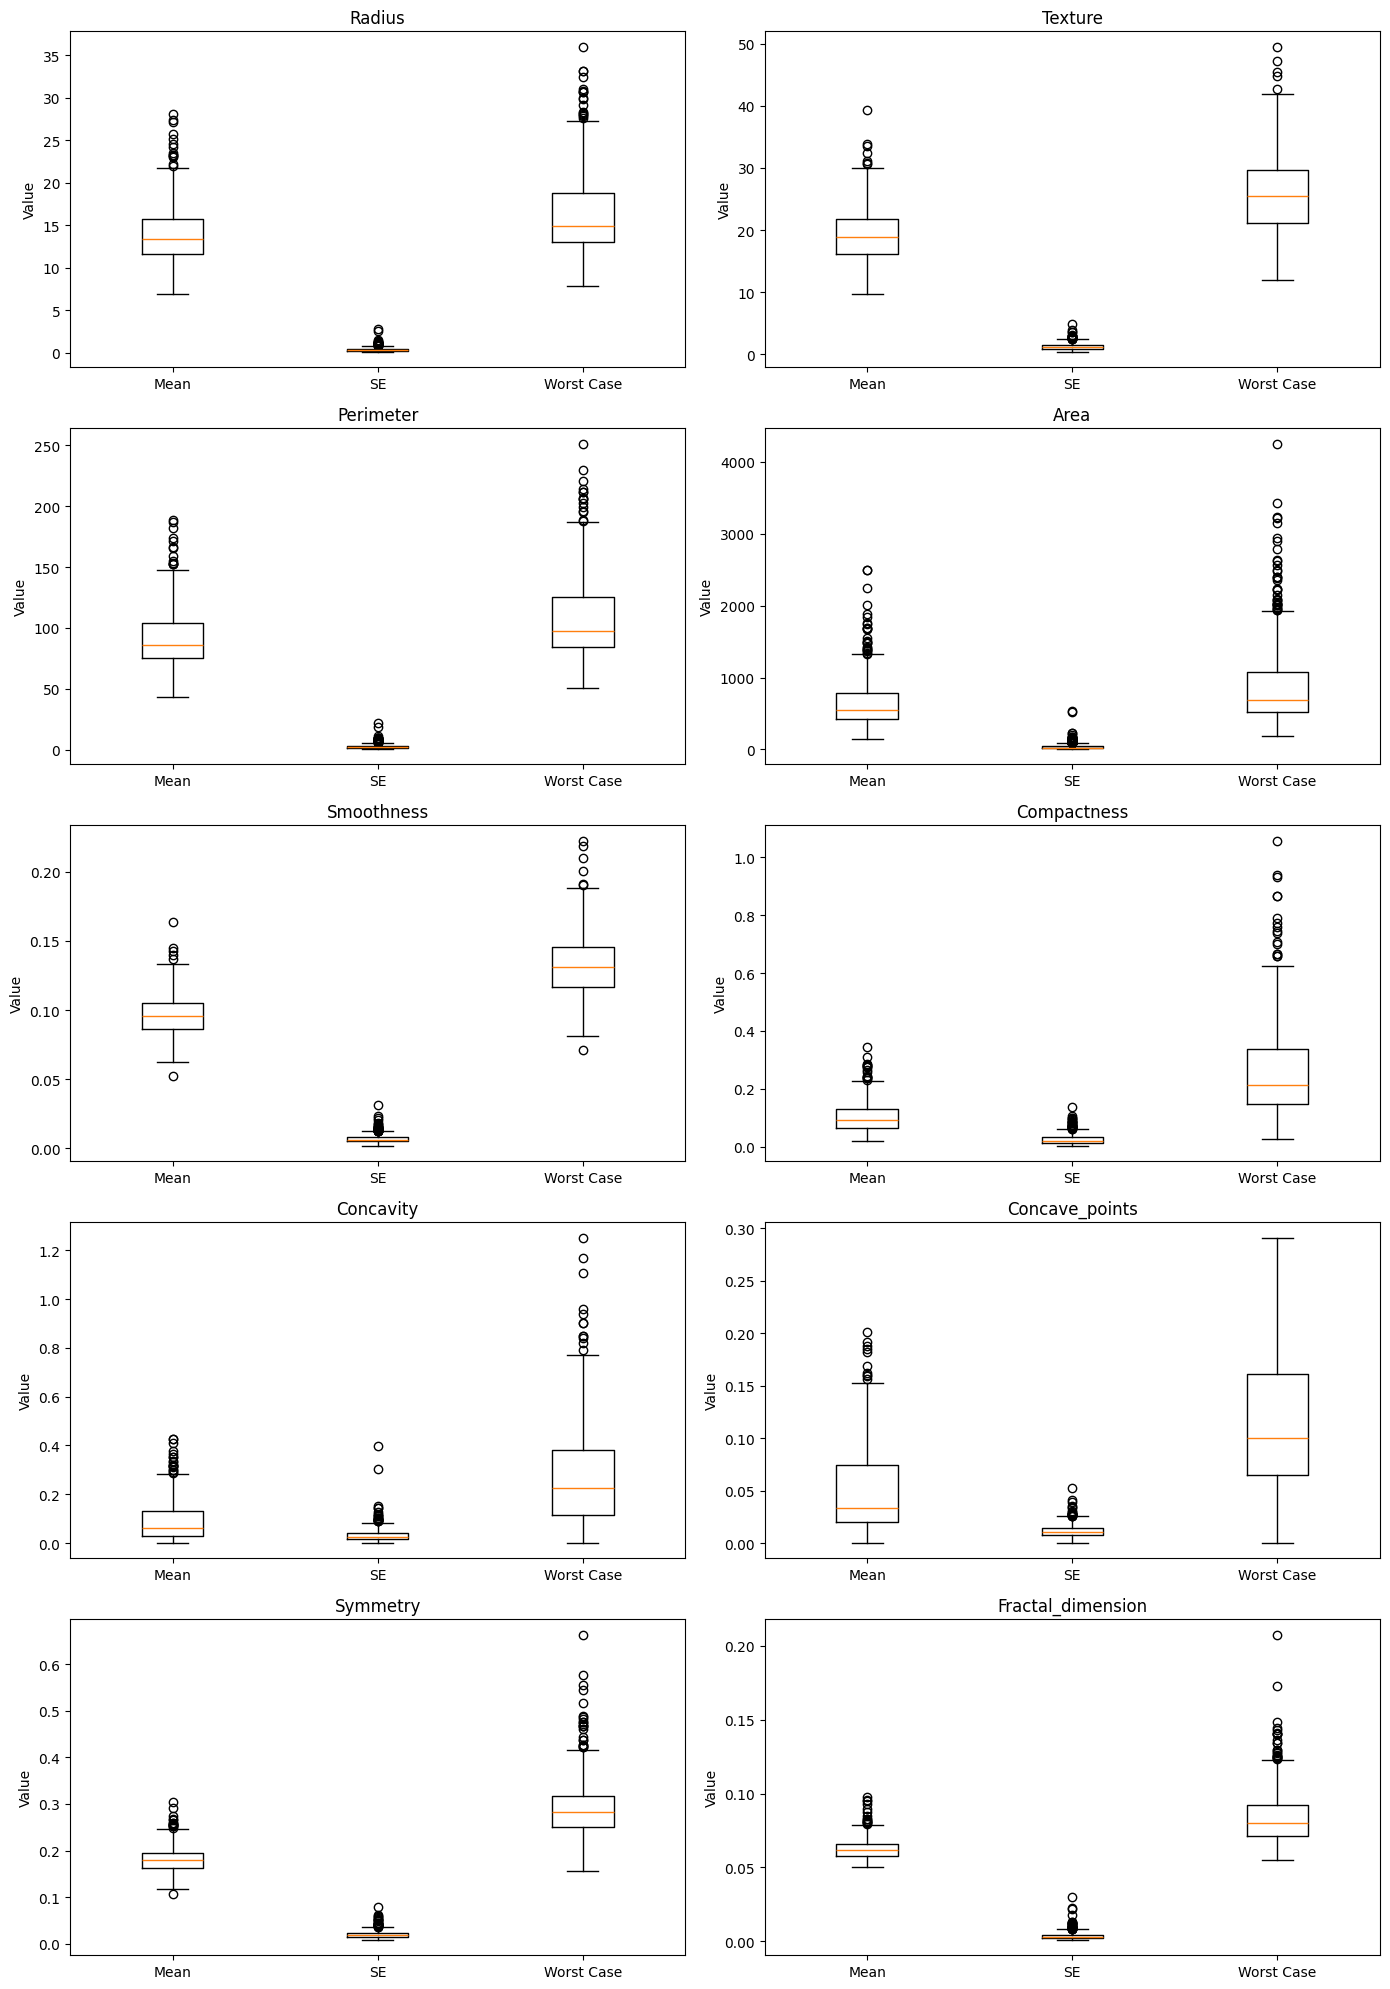

In [ ]:
features = [
    "radius", "texture", "perimeter", "area", "smoothness",
    "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"
]

# create figure: 5 rows × 2 columns
fig, axes = plt.subplots(5, 2, figsize=(14, 20))
axes = axes.ravel()

for i, feat in enumerate(features):
    cols = [f"{feat}1", f"{feat}2", f"{feat}3"]  # 1=mean, 2=SE, 3=worst case
    data = [X[c] for c in cols]

    axes[i].boxplot(data, tick_labels=["Mean", "SE", "Worst Case"])
    axes[i].set_title(feat.capitalize())
    axes[i].set_ylabel("Value")

plt.tight_layout()
plt.show()

#Data Cleaning

##Missing Value Check

In [ ]:
print("Missing values in X (features):")
print(X.isna().sum())
total_missing = X.isna().sum().sum()
print("Total missing values in X = ",total_missing)
print("\nMissing values in y (target):")
print(y.isna().sum())

Missing values in X (features):
radius1               0
texture1              0
perimeter1            0
area1                 0
smoothness1           0
compactness1          0
concavity1            0
concave_points1       0
symmetry1             0
fractal_dimension1    0
radius2               0
texture2              0
perimeter2            0
area2                 0
smoothness2           0
compactness2          0
concavity2            0
concave_points2       0
symmetry2             0
fractal_dimension2    0
radius3               0
texture3              0
perimeter3            0
area3                 0
smoothness3           0
compactness3          0
concavity3            0
concave_points3       0
symmetry3             0
fractal_dimension3    0
dtype: int64
Total missing values in X =  0

Missing values in y (target):
Diagnosis    0
dtype: int64


##Data Imputation

In [ ]:
# We will do class-specific mean imputation
X_imputed = X.copy()

if total_missing > 0:
    # loop over each feature column
    for col in X_imputed.columns:
        # compute the mean of this feature grouped by "Diagnosis" in y
        class_means = X_imputed.groupby(y["Diagnosis"])[col].transform("mean")
        # fill nans in this feature with its class mean
        X_imputed[col] = X_imputed[col].fillna(class_means)
    print("Missing values after imputation:\n", X_imputed.isna().sum())

else:
    print("\nNo imputation as no missing values found")


No imputation as no missing values found


##Min-Max Scaling

In [ ]:
# compute min and max per column
mins = X_imputed.min()
maxs = X_imputed.max()

# apply scaling
X_scaled = (X_imputed - mins) / (maxs - mins)

##Transforming Class Labels

In [ ]:
y_num = y.copy()

# map labels : B to 0 and M to 1
y_num["Diagnosis"] = y_num["Diagnosis"].map({"B": 0, "M": 1})
print(y_num)

     Diagnosis
0            1
1            1
2            1
3            1
4            1
..         ...
564          1
565          1
566          1
567          1
568          0

[569 rows x 1 columns]


## Splitting the Dataset into Training and Testing Sets (with Stratification)

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
# 70/30 Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_num,
train_size=0.7, random_state=42, stratify=y_num)

print("X_train shape: ", X_train.shape,"\tY_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape,"\ty_test shape", y_test.shape)

X_train shape:  (398, 30) 	Y_train shape:  (398, 1)
X_test shape:  (171, 30) 	y_test shape (171, 1)


#Modeling k-Nearest Neighbors (k-NN) classifier

F1 scores by k:
    k        f1
0   1  0.920635
1   2  0.924370
2   3  0.959350
3   4  0.950820
4   5  0.959350
5   6  0.950820
6   7  0.959350
7   8  0.950820
8   9  0.967742
9  10  0.933333

Best k =  9  with F1 =  0.968


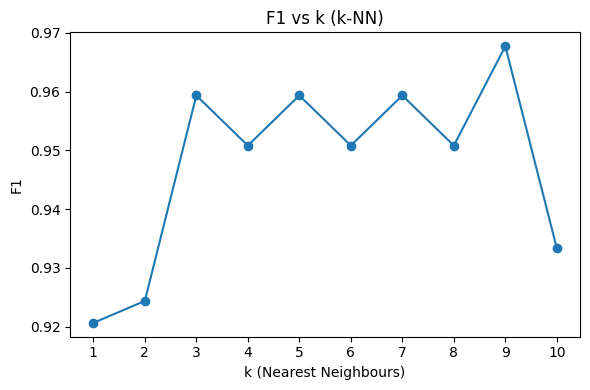

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

rows = []

# k=1..10 and record F1 score on the test set
for k in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, np.ravel(y_train))
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    rows.append({"k": k, "f1": f1})

results = pd.DataFrame(rows)
print("F1 scores by k:")
print(results)

# Pick best k
best_idx = results["f1"].idxmax()
best_k = int(results.loc[best_idx, "k"])
best_f1 = float(results.loc[best_idx, "f1"])
print("\nBest k = ",best_k," with F1 = ",round(best_f1,3))

# Plot F1 vs k
plt.figure(figsize=(6, 4))
plt.plot(results.k, results.f1, marker="o")
plt.xlabel("k (Nearest Neighbours)")
plt.ylabel("F1")
plt.title("F1 vs k (k-NN)")
plt.xticks(results.k)
plt.tight_layout()
plt.show()


## Conclusion
k=9 achieved the highest test F1=0.968, giving the best balance of stability and performance on this dataset. Therefore, we select **k=9** for the final model.

## Training model with best k and showing support for results

Accuracy (test): 97.66 %

Classification report (test):
              precision    recall  f1-score   support

           0     0.9640    1.0000    0.9817       107
           1     1.0000    0.9375    0.9677        64

    accuracy                         0.9766       171
   macro avg     0.9820    0.9688    0.9747       171
weighted avg     0.9775    0.9766    0.9764       171



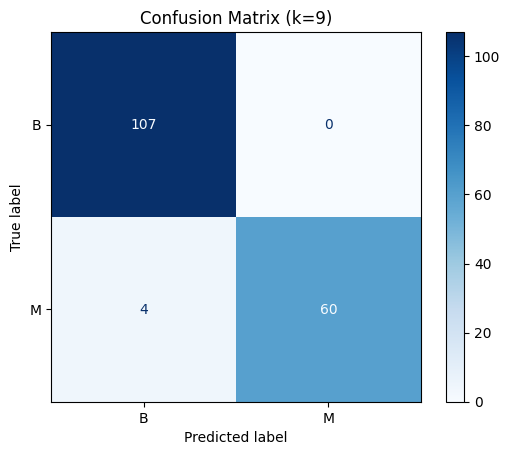

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
# Train final model at best k
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train,np.ravel(y_train))
y_pred = knn_final.predict(X_test)

print("Accuracy (test):", round(accuracy_score(y_test, y_pred)*100,2),"%")
print("\nClassification report (test):")
print(classification_report(y_test, y_pred, digits=4))
# printing confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["B", "M"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (k="+str(best_k)+")")
plt.show()

##Model Evaluation
The final k-NN model with k=9 achieved high accuracy and a strong F1 performance, indicating a good balance between precision and recall.  
The classification report shows that both benign and malignant cases are classified reliably, and the confusion matrix confirms only a small number (=4) of misclassifications (false positives and true negatives).  
Overall, this suggests the model is effective for supporting breast cancer diagnosis.

#Ethical Consideration of Solution
The Wisconsin Diagnostic Breast Cancer dataset consists of very sensitive medical information, so definitely ethical responsibilities do apply under the CMA Code of Ethics and Professionalism. Some key ethical principles include protecting and maintaining confidentiality, avoiding any harm, and  ensuring fairness. In practice, this means to always be mindful of the fact that false positives may cause distress while false negatives could cause a delay in medical treatment, and that the patient data has to be handled carefully and securely to maintain trust and dignity.

For further modeling of this dataset, these principles imply that models should be transparent and easily interpretable. Models should be carefully evaluated for fairness across different patient groups, and should be used for decision support, early diagnosis and greater efficiency in diagnosis rather than a complete replacement for physician judgment. Researchers must acknowledge limitations and should not overstate their results. In short, responsible use of this dataset requires ensuring privacy, rigorous validation, and focus on improving patient care without a compromise on ethical obligations. Patient welfare should be the most important guiding principle to ensure that using predictive models enhances patient care rather than harm it.

#References
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

https://stackoverflow.com/questions/15821116/how-to-measure-the-accuracy-of-knn-classifier-in-python

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

https://stackoverflow.com/questions/76784223/how-to-plot-a-confusion-matrix

Google Colab Gemini